In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from RF_Shap import RFShap

In [2]:
data_dir = '/home/matthewvowels/GitHub/Psych_ML/Shapley_Forest/'
file = 'simple_dataset.csv'

dataset = pd.read_csv(os.path.join(data_dir, file), delim_whitespace=False)
cols = dataset.columns

dataset = dataset.iloc[:100]
dataset['male'] = dataset.male + np.random.randint(2, size=(len(dataset)))
dataset.head()

,age,children,male,female,ftm,mtf,straight,gay,lesbian
0,30.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,32.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,23.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0
3,31.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,14.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


In [3]:
od = '/home/matthewvowels/GitHub/Psych_ML/Shapley_Forest/output'
model_dir = '/home/matthewvowels/GitHub/Psych_ML/Shapley_Forest/output/model.sav'

# Created RFShap Class/environment:
shap_env = RFShap(model_dir=model_dir, exclude_vars=None, outcome_var='male',
                  output_dir=od, random_seed=42, class_='RF',type_='cls', balanced='balanced',
                 trn_tst_split=0.6, k_cv='split', k=5)

# Feed in desired dataset. This removes exclude_vars, and splits into X, y,
# as well as making train test splits
dataset, X, y, xtr, xts, ytr, ytst  = shap_env.munch(dataset=dataset)

Preparing dataset...


In [4]:
# here is a list of possible config settings for each classifier (we are using config_cls for 
# a random forest classifier)

config_reg = {'n_estimators': 200, 'criterion': 'mse', 'max_depth': None, 'min_samples_split': 2,
          'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto',
          'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None,
          'bootstrap': True, 'oob_score': True, 'n_jobs': None, 'random_state': None, 
          'verbose': 0, 'warm_start': False, 'max_samples': None}

config_cls = {'n_estimators': 200, 'max_depth': None, 'min_samples_split': 2,
          'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto',
          'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 
          'bootstrap': True, 'oob_score': True, 'n_jobs': None, 'random_state': None, 
          'verbose': 0, 'warm_start': False, 'max_samples': None}

config_linreg = {'fit_intercept': True, 'normalize': False, 'n_jobs': None}


config_logreg = {'penalty': 'l2', 'dual': False, 'tol': 1e-4, 'C': 1.0, 'fit_intercept': True,
                'intercept_scaling': 1.0, 'solver': 'lbfgs', 'class_weight': None, 'max_iter': 100, 'multi_class': 'auto',
                'verbose': 0, 'n_jobs': None}


# init a model with the config settings:
model = shap_env.make_model(config=config_cls)

# decide one some tunable parameters (we are using tunable_params_rf because we have a RF classifier)
tunable_params_rf = ['n_estimators', 'max_depth', 'max_features']
tunable_params_linreg = ['normalize', 'fit_intercept']
tunable_params_logreg = ['penalty', 'dual', 'tol', 'C', 'fit_intercept', 'solver', 'max_iter']

# tunable_params_rf = ['max_depth'] 
# identify some good hyperparameters by doing a random search:
tuned_model = shap_env.tune_model(tunable_params=tunable_params_rf, folds=5, n_iter=100) 

# now we need to train the model:
model, report = shap_env.train_test()

# models can be saved and loaded like this (it uses the previously set model_dir, but you can
# also set a new one as an arugment if you wish!)
shap_env.save_model()
model = shap_env.load_model()

Creating fresh model...
Created:  BalancedRandomForestClassifier(n_estimators=200, oob_score=True)
Tuning the following parameters:  ['n_estimators', 'max_depth', 'max_features']
Creating fresh model...
Created:  BalancedRandomForestClassifier()
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 333 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.6min finished
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


best params are:  {'n_estimators': 50, 'max_features': 'sqrt', 'max_depth': 10}
Creating fresh model...
Created:  BalancedRandomForestClassifier(max_depth=10, max_features='sqrt',
                               n_estimators=50)
Accuracy: 40.0%


Running Shap Explainer using the same train/test split you used to train the model.


model_output = "margin" has been renamed to model_output = "raw"
Setting feature_perturbation = "tree_path_dependent" because no background data was given.


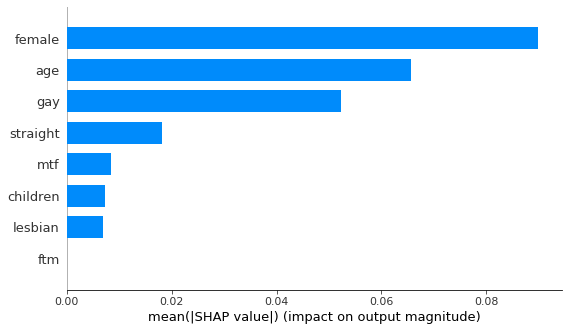

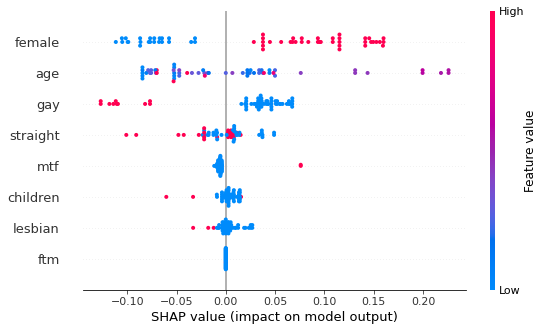

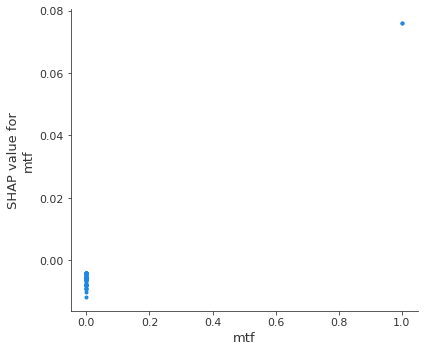

In [5]:
# now we have a trained model with reasonably good training parameters we can do some interpretation
# this first bit creates and saves the output of the Shap explainer:
explainer, shap_vals = shap_env.run_shap_explainer(modell=model)
                                                   
# to create plots (and automatrically save them to the output directory):
shap_env.shap_plot(shap_vals=shap_vals, specific_var='mtf', interaction_var=None, classwise=False, class_ind=1)

Bootstrap number:  20


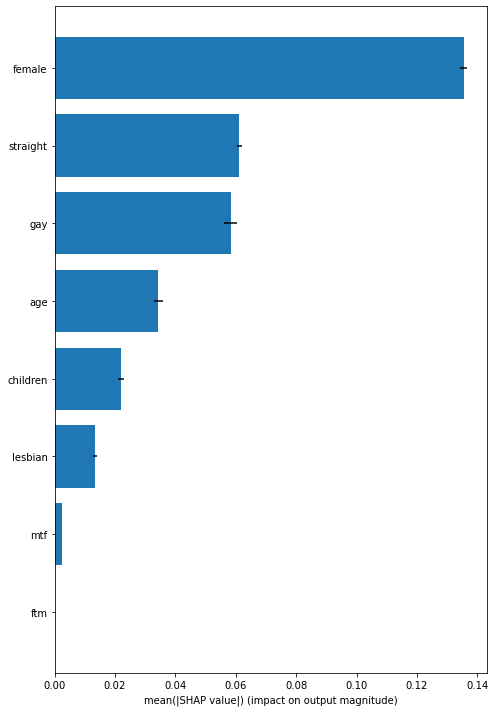

,age,children,female,ftm,mtf,straight,gay,lesbian
0,0.034316,0.021950,0.135441,0.0,0.002434,0.061211,0.058261,0.013392
1,0.000787,0.000497,0.000541,0.0,0.000038,0.000488,0.001158,0.000330


In [6]:
# finally, let's bootstrap over Shapley feature importances and get some C.I.s:
shap_vals_bootstrap, results = shap_env.shap_bootstrap(modell=model, retrain=False, n_bootstraps=30, n_samples=50, class_ind=0)


# N.B. these results don't look like much, because we are only using a small toy dataset
results